## **이상 탐지**

In [63]:
import os
import torch
import requests
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from io import BytesIO
from datetime import datetime
from tqdm import tqdm, trange

In [30]:
server_url = 'http://dmlab.kaist.ac.kr/~geonlee/1300_1500/'

In [57]:
# 파일명을 날짜로 변환하는 함수
def file_to_date(filename, datetime_form=False):
    term = filename.split('/')[-1][:-4].split('_')[-1]
    year, month, day, hour, minute = term[0:4], term[4:6], term[6:8], term[8:10], term[10:12]
    if datetime_form:
        return datetime(int(year), int(month), int(day), int(hour), int(minute), 0)
    return '{}-{}-{} {}:{}'.format(year, month, day, hour, minute)

In [50]:
# 이미지를 플롯하기 위한 함수
def plot(imgs, dates):
    orig_img = imgs[0]
    imgs = imgs[1:]
    
    if not isinstance(imgs[0], list):
        imgs = [imgs]
    
    num_rows = len(imgs)
    num_cols = len(imgs[0]) + 1
    
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(50,20))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap="gray")
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    
    keys = ['Top-{}'.format(i+1) for i in range(num_cols)]
    for i in range(len(keys)):
        axs[0,i].set(title=keys[i] + '\n' + dates[i])
        axs[0,i].title.set_size(60)
        
    plt.tight_layout()
    plt.show()

### 데이터 및 모델 로드

In [21]:
with open('data_list.pkl', 'rb') as f:
    data_list = pkl.load(f)

with open('date_list.pkl', 'rb') as f:
    date_list = pkl.load(f)
    
print('Number of images: {}'.format(len(data_list)))

Number of images: 279176


In [22]:
# (1) delta = 6hours and (2) No augmentation으로 학습한 metric learning 모델
with open('emb_metric_6_noaug.pkl', 'rb') as f:
    emb = pkl.load(f).numpy()

### **이상 탐지 유형 1: 유사도 기반 이상탐지**
모델 학습을 통해 얻은 임베딩을 활용하여 LOF, Isolated Forest 등을 학습.

In [14]:
from pyod.models.lof import LOF
from pyod.models.iforest import IForest

#### LOF: 학습

In [15]:
# LOF (시간이 걸릴 수 있습니다.)
clf_lof = LOF()
clf_lof.fit(emb)
scores_lof = clf_lof.decision_scores_

#### LOF: Top-K 추출

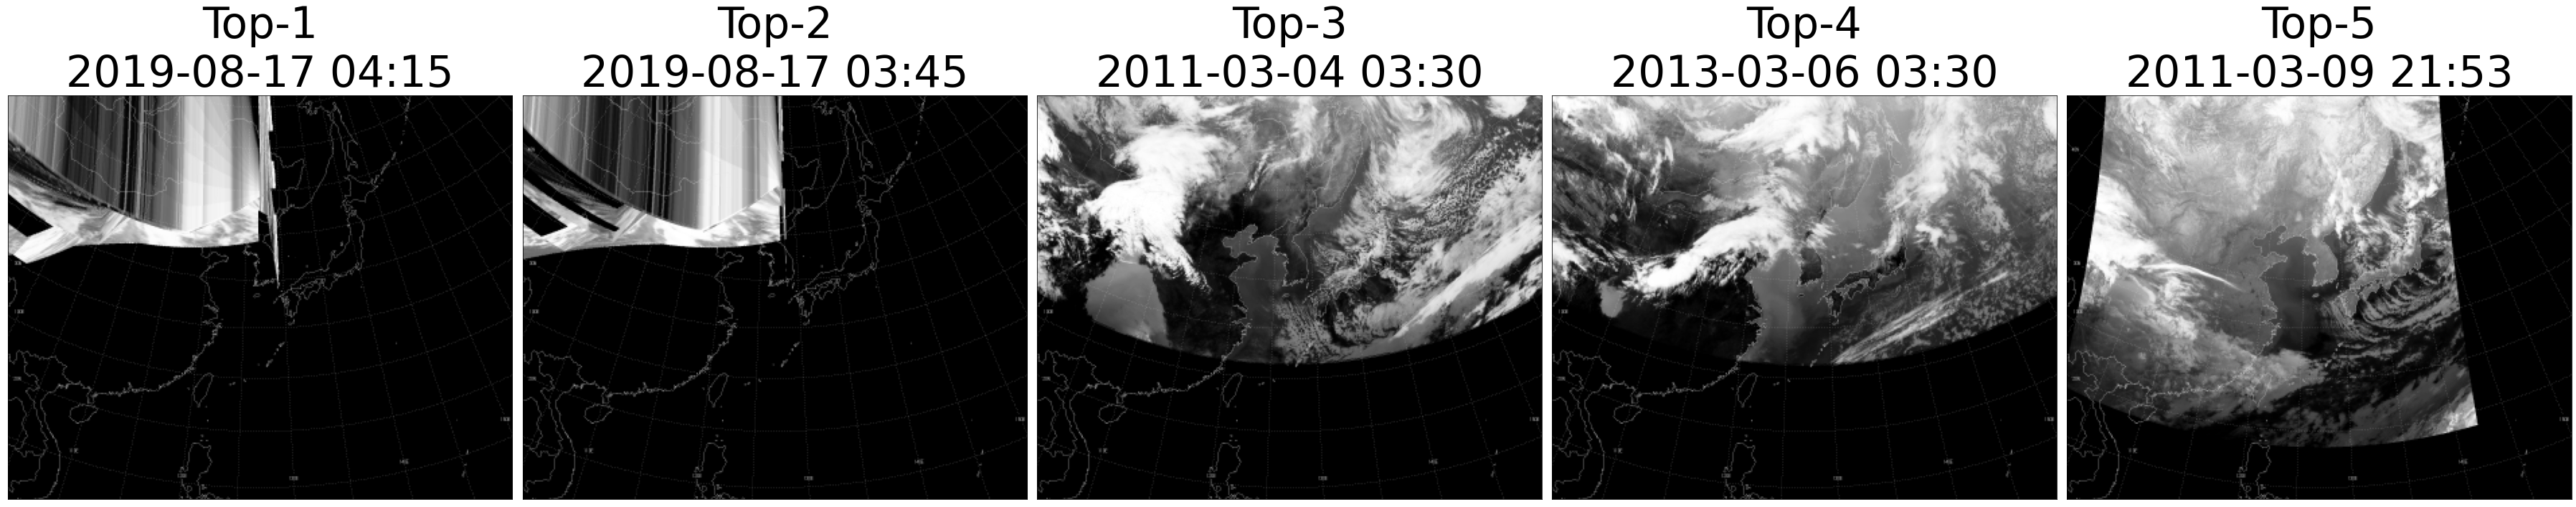

In [51]:
# k를 조절 가능
k = 5
topk_lof = scores_lof.argsort()[-k:][::-1]

topk_images = []
topk_dates = []

for index in topk_lof:
    img_url = os.path.join(server_url, data_list[index])
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    img = transforms.ToPILImage()(transforms.ToTensor()(img).squeeze(0))
    topk_images.append(img)
    topk_dates.append(file_to_date(data_list[index]))
plot(topk_images, topk_dates)

#### Isolated Forest: 학습

In [16]:
# Isolated Forest (시간이 걸릴 수 있습니다.)
clf_iforest = IForest()
clf_iforest.fit(emb)
scores_iforest = clf_iforest.decision_scores_

#### Isolated Forest: Top-k 추출

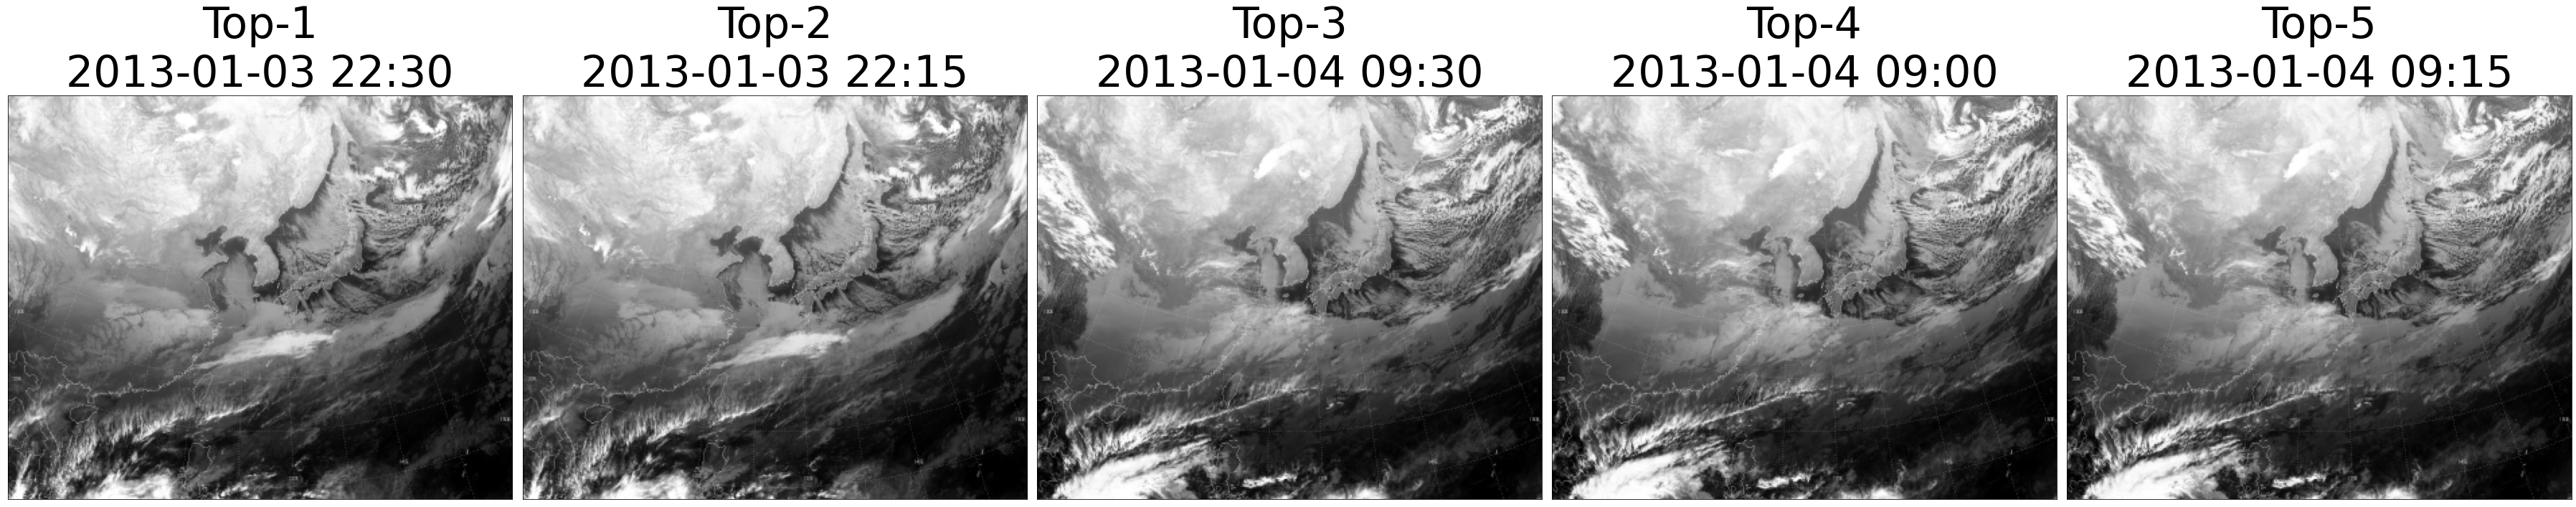

In [52]:
# k를 조절 가능
k = 5
topk_iforest = scores_iforest.argsort()[-k:][::-1]

topk_images = []
topk_dates = []

for index in topk_iforest:
    img_url = os.path.join(server_url, data_list[index])
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    img = transforms.ToPILImage()(transforms.ToTensor()(img).squeeze(0))
    topk_images.append(img)
    topk_dates.append(file_to_date(data_list[index]))
plot(topk_images, topk_dates)

### **이상 탐지 유형 2: 입력 변화량 기반 이상탐지**
모델 학습을 통해 얻은 임베딩이 시간에 따라 어느 정도 변화하는지 측정

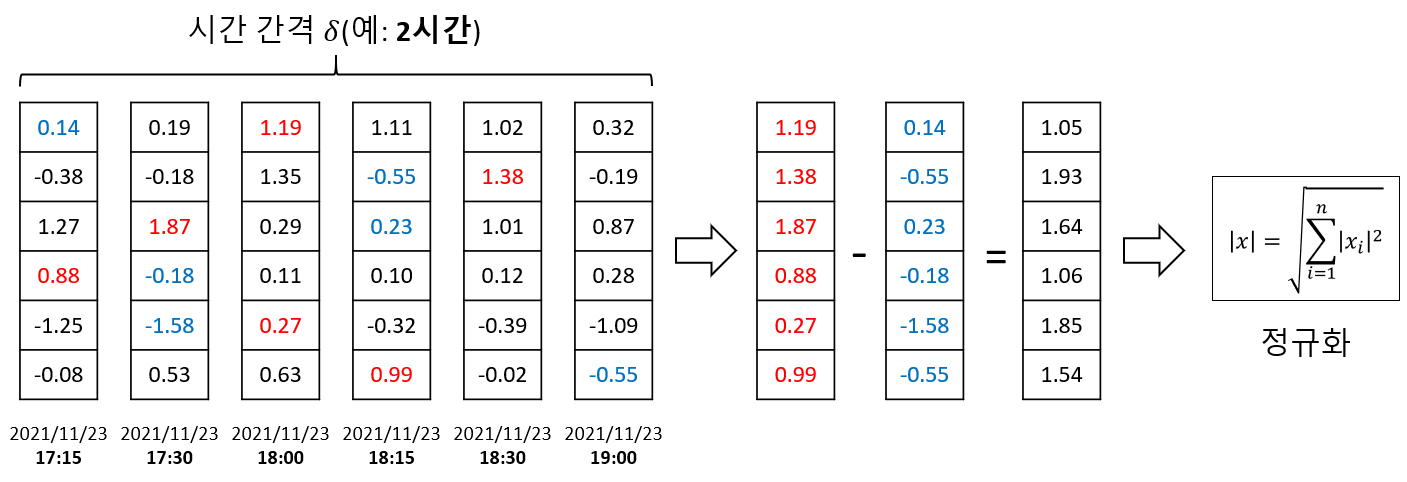

In [55]:
from IPython.display import Image
Image(filename='images/temporal_anomaly.PNG')

시간 간격 $\delta$ 동안의 영상 임베딩의 최소-최대 임베딩을 구한 뒤, 정규화 값을 계산.

임베딩의 변화량이 클수록 높은 값을 나타내도록 설계

In [65]:
# 시간 간격을 3시간으로 설정
DELTA = 3600 * 3 

maxmin_emb = []
_emb = torch.from_numpy(emb)

for i in trange(emb.shape[0]):
    date_i = file_to_date(data_list[i], True)
    max_emb = _emb[i].clone()
    min_emb = _emb[i].clone()
    j = i + 1
    while j < len(data_list):
        date_j = file_to_date(data_list[j], True)
        delta = (date_j - date_i).total_seconds()
        if delta > DELTA:
            break
        max_emb = torch.max(max_emb, _emb[j])
        min_emb = torch.min(min_emb, _emb[j])
        j += 1
    cur_emb = max_emb - min_emb
    maxmin_emb.append(cur_emb)
    
maxmin_emb = torch.stack(maxmin_emb, 0).numpy()

100%|██████████| 279176/279176 [00:59<00:00, 4663.80it/s]


In [67]:
# 정규화 (이상 점수)
scores_maxmin = np.linalg.norm(maxmin_emb, ord=2, axis=1)

#### Maxmin Embedding: Top-k 추출

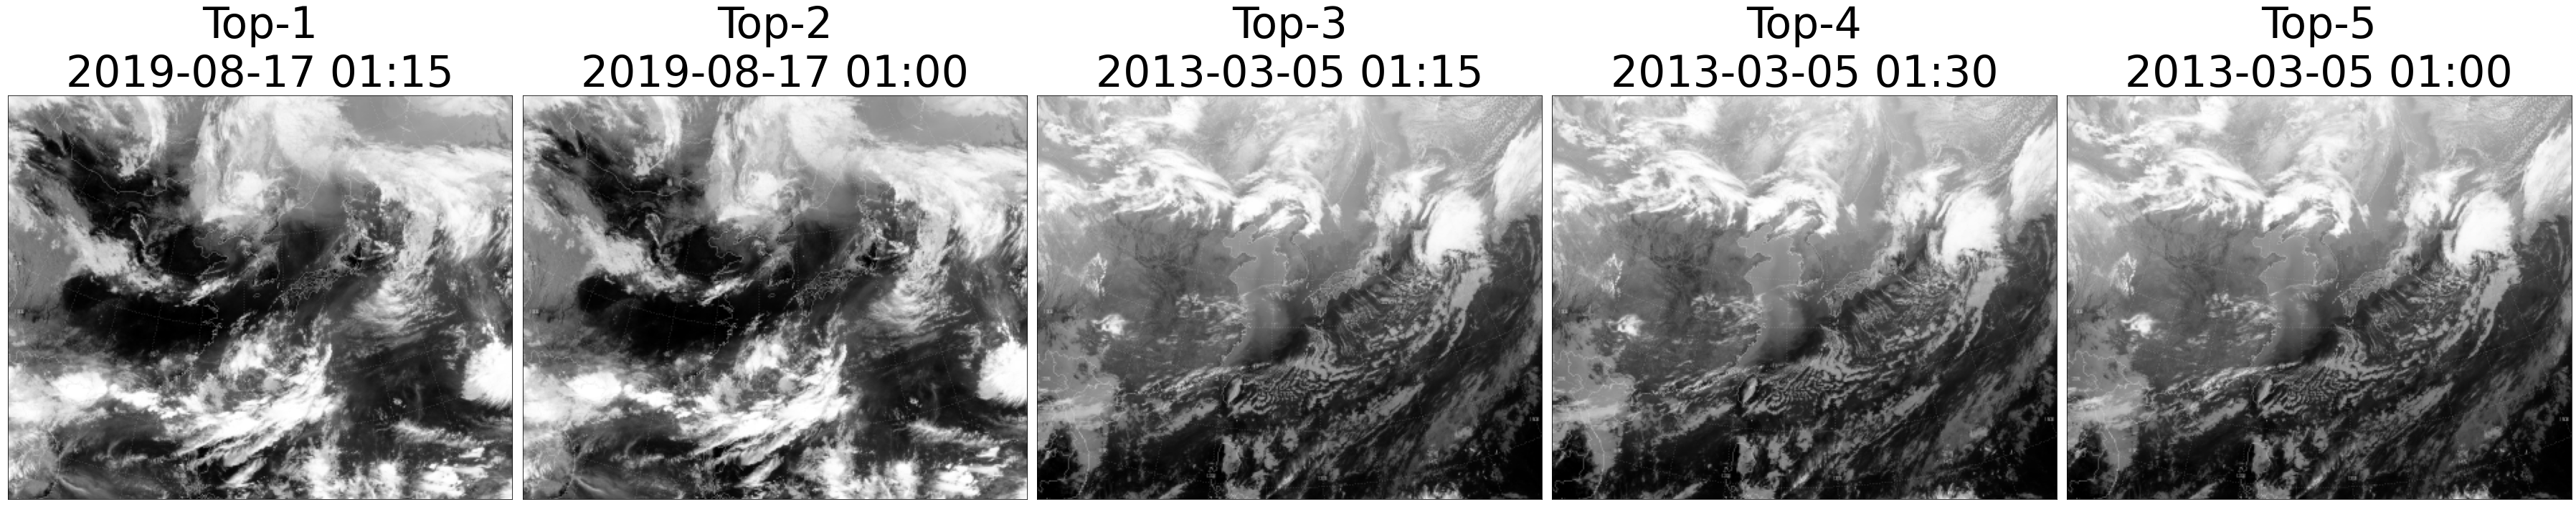

In [68]:
# k를 조절 가능
k = 5
topk_maxmin = scores_maxmin.argsort()[-k:][::-1]

topk_images = []
topk_dates = []

for index in topk_maxmin:
    img_url = os.path.join(server_url, data_list[index])
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    img = transforms.ToPILImage()(transforms.ToTensor()(img).squeeze(0))
    topk_images.append(img)
    topk_dates.append(file_to_date(data_list[index]))
plot(topk_images, topk_dates)